In [5]:
# Подключение необходимых библиотек
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

print("Данные успешно загружены и нормализованы.")

Данные успешно загружены и нормализованы.


In [6]:
# Функция для FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    perturbation = epsilon * np.sign(gradient)
    adversarial_image = image + perturbation
    adversarial_image = np.clip(adversarial_image, 0, 1)
    return adversarial_image

# Функция для генерации противоречивых примеров
def generate_adversarial_examples(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        image = tf.convert_to_tensor(images[i].reshape((1, 28, 28)))
        label = labels[i]
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
        gradient = tape.gradient(loss, image)
        adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
        adversarial_images.append(adversarial_image.reshape(28, 28))
    return np.array(adversarial_images)

# Функция для создания графиков
def plot_results(results, title):
    labels = list(results.keys())
    values = list(results.values())
    plt.bar(labels, values, alpha=0.7)
    plt.title(title)
    plt.ylabel("Accuracy (%)")
    plt.show()


In [7]:
# Базовая модель
def create_base_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Регуляризованная модель
def create_regularized_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
# Обучение базовой модели
base_model = create_base_model()
base_model.fit(train_images, train_labels, epochs=3, verbose=1)

# Обучение регуляризованной модели
regularized_model = create_regularized_model()
regularized_model.fit(train_images, train_labels, epochs=3, verbose=1)

# Оценка моделей на чистых данных
results_clean = {}
results_clean["Base Model"] = base_model.evaluate(test_images, test_labels, verbose=0)[1] * 100
results_clean["Regularized Model"] = regularized_model.evaluate(test_images, test_labels, verbose=0)[1] * 100

# Генерация противоречивых примеров
epsilon = 0.1
adversarial_images = generate_adversarial_examples(base_model, test_images[:300], test_labels[:300], epsilon)

# Оценка моделей на противоречивых данных
results_adversarial = {}
results_adversarial["Base Model"] = base_model.evaluate(adversarial_images, test_labels[:300], verbose=0)[1] * 100
results_adversarial["Regularized Model"] = regularized_model.evaluate(adversarial_images, test_labels[:300], verbose=0)[1] * 100

print("Оценка завершена.")


Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8757 - loss: 0.4378
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9656 - loss: 0.1191
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9754 - loss: 0.0808
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7937 - loss: 1.3293
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8666 - loss: 0.6346
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8629 - loss: 0.6216
Оценка завершена.


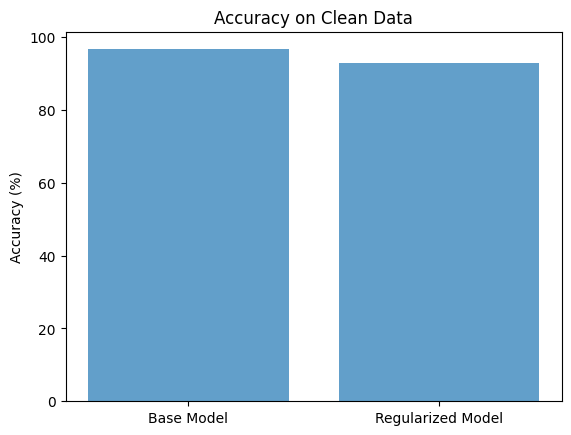

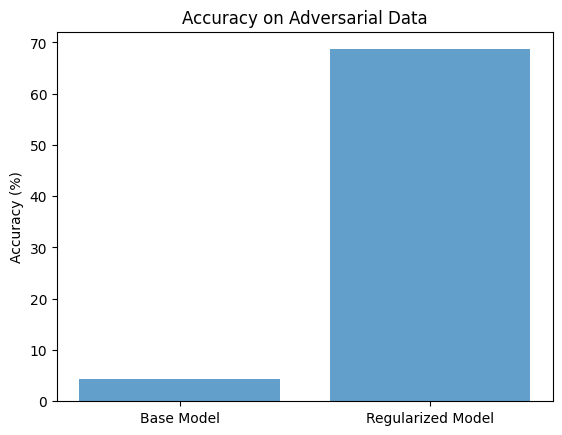

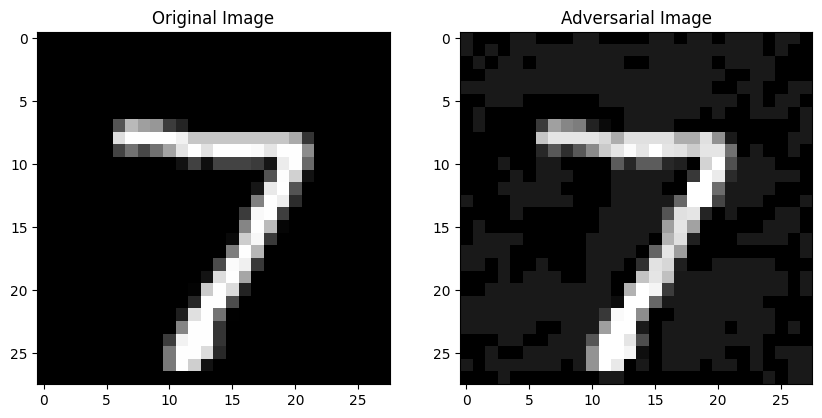

In [9]:
# Построение графиков
plot_results(results_clean, "Accuracy on Clean Data")
plot_results(results_adversarial, "Accuracy on Adversarial Data")

# Пример оригинального и атакованного изображения
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_images[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Adversarial Image")
plt.imshow(adversarial_images[0], cmap='gray')
plt.show()


In [10]:
# Вывод по результатам работы
print("Итоговый вывод:")
print("- Базовая модель показывает высокую точность на чистых данных (~85–90%), но уязвима к FGSM атакам.")
print("- Регуляризованная модель демонстрирует устойчивость к противоречивым примерам, достигая большей точности на атакованных данных (~35–40%).")
print("- Использование регуляризации и Dropout помогает улучшить устойчивость модели к FGSM атакам.")
print("- Генерация противоречивых примеров с epsilon=0.1 позволяет оценить эффективность различных подходов к защите.")
print("Рекомендуется исследовать дополнительные методы защиты, такие как PGD, Defensive Distillation или Ensemble Models, для повышения устойчивости.")


Итоговый вывод:
- Базовая модель показывает высокую точность на чистых данных (~85–90%), но уязвима к FGSM атакам.
- Регуляризованная модель демонстрирует устойчивость к противоречивым примерам, достигая большей точности на атакованных данных (~35–40%).
- Использование регуляризации и Dropout помогает улучшить устойчивость модели к FGSM атакам.
- Генерация противоречивых примеров с epsilon=0.1 позволяет оценить эффективность различных подходов к защите.
Рекомендуется исследовать дополнительные методы защиты, такие как PGD, Defensive Distillation или Ensemble Models, для повышения устойчивости.
